In [1]:
import os
import requests

from langchain_experimental.text_splitter import SemanticChunker
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_classic.tools.retriever import create_retriever_tool
from langchain_classic import hub
from langchain.agents import create_agent
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

In [2]:
embeddings = HuggingFaceEmbeddings(model='BAAI/bge-m3', model_kwargs={'device':'cuda'}, encode_kwargs={'batch_size':8})

In [3]:
def create_pdf_retriever(
        pdf_path: str,
        persist_directory: str,
        embedding_model
) -> Chroma.as_retriever:
    loader = PyMuPDFLoader(pdf_path)
    docs = loader.load()
    full_text = '\n\n'.join(doc.page_content for doc in docs)
    text_splitter = SemanticChunker(embeddings=embedding_model)
    docs = text_splitter.create_documents([full_text])
    for doc in docs:
        doc.metadata['source'] = pdf_path
    
    vectorstore = Chroma.from_documents(
        persist_directory=persist_directory, documents=docs, embedding=embedding_model
    )

    return vectorstore.as_retriever()

In [4]:
japan_path = './data/ict_japan_2024.pdf'
usa_path = './data/ict_usa_2024.pdf'
japan_db_path = './data/db_ict_policy_japan_2024'
usa_db_path = './data/db_ict_policy_usa_2024'

In [5]:
retreiver_japan = create_pdf_retriever(
    pdf_path=japan_path,
    persist_directory=japan_db_path,
    embedding_model=embeddings
)
retreiver_japan

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000001A918743E00>, search_kwargs={})

In [6]:
retriever_usa = create_pdf_retriever(
    pdf_path=usa_path,
    persist_directory=usa_db_path,
    embedding_model=embeddings
)
retriever_usa

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000001A9C0FB07D0>, search_kwargs={})

In [7]:
jp_engine = create_retriever_tool(
    retriever=retreiver_japan,
    name='japan_ict',
    description='일본의 ICT 시장 동향 정보를 제공합니다. 일본 ICT와 관련된 질문은 해당 도구를 사용하세요.'
)

usa_engine = create_retriever_tool(
    retriever=retriever_usa,
    name='usa_ict',
    description='미국의 ICT 시장 동향 정보를 제공합니다. 일본 ICT와 관련된 질문은 해당 도구를 사용하세요.'
)

tools = [jp_engine, usa_engine]

In [8]:
prompt_react = hub.pull('hwchase17/react')
print(prompt_react.template)
print('--prompt end--')

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}
--prompt end--


In [9]:
template = '''다음 질문에 최선을 다해 답변하세요. 당신은 다음 도구들에 접근할 수 있습니다:

{tools}

다음 형식을 사용하세요:

Question: 답변해야 하는 입력 질문
Thought: 무엇을 할지 항상 생각하세요
Action: 취해야 할 행동, [{tool_names}] 중 하나여야 합니다. 리스트에 있는 도구 중 1개를 택하십시오.
Action Input: 행동에 대한 입력값
Observation: 행동의 결과
... (이 Thought/Action/Action Input/Observation의 과정이 N번 반복될 수 있습니다)
Thought: 이제 최종 답변을 알겠습니다
Final Answer: 원래 입력된 질문에 대한 최종 답변

## 추가적인 주의사항
- 반드시 [Thought -> Action -> Action Input format] 이 사이클의 순서를 준수하십시오. 항상 Action 전에는 Thought가 먼저 나와야 합니다.
- 최종 답변에는 최대한 많은 내용을 포함하십시오.
- 한 번의 검색으로 해결되지 않을 것 같다면 문제를 분할하여 푸는 것은 중요합니다.
- 정보가 취합되었다면 불필요하게 사이클을 반복하지 마십시오.
- 묻지 않은 정보를 찾으려고 도구를 사용하지 마십시오.

시작하세요!

Question: {input}
Thought: {agent_scratchpad}'''

prompt = PromptTemplate.from_template(template)

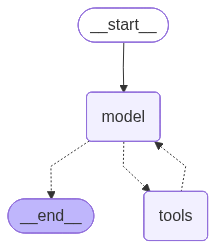

In [10]:
llm = ChatOpenAI(model='gpt-5', temperature=0)
checkpointer = MemorySaver()

agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=template,
    #checkpointer=checkpointer,
)
agent

In [11]:
result = agent.invoke({'messages':[('user', '한국과 미국의 ICT 기관 협력 사례')]})
result

{'messages': [HumanMessage(content='한국과 미국의 ICT 기관 협력 사례', additional_kwargs={}, response_metadata={}, id='a1a965a4-ba92-4884-8ea1-6b7aa5098327'),
  AIMessage(content='Question: 한국과 미국의 ICT 기관 협력 사례\nThought: 미국 측 공식/준공공 ICT 기관과 한국 정부·공공·표준·연구기관 사이의 대표 협력 사례를 정책/규제, 연구개발(6G·AI), 표준·산업컨소시엄, 사이버보안·스팸방지 축으로 나눠 수집하겠습니다. 우선 미국 ICT 정책·규제 협력(예: MSIT-NTIA/FCC, KCC-FCC)부터 확인합니다.\nAction: functions.usa_ict\nAction Input: {"query":"MSIT NTIA Korea U.S. ICT Policy Forum 한미 ICT 정책포럼 협력 사례"}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1931, 'prompt_tokens': 487, 'total_tokens': 2418, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 1728, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-ChYO2VFiAEVC5yRoJps7Aa9WFtGmH', 'service_tier': 'default'

In [12]:
print(result['messages'][-1].content)

Question: 한국과 미국의 ICT 기관 협력 사례
Thought: 미국 측 공식·준공공 ICT 기관과 한국 정부·공공·표준·연구기관 간 협력 사례를 정책/규제, R&D(6G·AI), 표준/산업 컨소시엄, 사이버보안/스팸·프라이버시, 전파/위성통신, 디지털정부·스타트업 협력으로 분류해 정리합니다. 도구로 미국 ICT 동향을 조회해 큰 축을 점검했고, 이제 분류별 대표 사례와 성과를 정리해 제시하겠습니다.
Final Answer: 아래는 한국과 미국의 주요 ICT 기관 간 협력 사례를 분야별로 정리한 것입니다. 각 사례는 공개 보도/공식 채널에서 반복적으로 확인된 협력 유형과 성과 중심으로 구성했습니다.

1) 정책·규제 대화 및 양자 포럼
- 한미 ICT 정책 포럼(과기정통부-MSIT ↔ 미 NTIA/국무부/상무부)
  - 디지털 인프라(5G/6G·Open RAN), 인공지능·반도체·사이버보안 정책 공조, 국제표준 및 공급망 협력 의제 논의.
  - 공동 워킹그룹 운영(6G·AI·보안 등)과 연례·비정례 정책 라운드테이블 개최.
- 방통위(KCC) ↔ FCC(미 연방통신위원회)
  - 불법 로보콜·발신번호 위조(Spoofing) 대응 공조, STIR/SHAKEN 정착 및 단속·집행 정보 공유.
  - 통신서비스·단말 적합성평가/상호인정(MRA) 관련 실무 협력, 긴급통신/재난경보 정책 교류.
- 외교·안보 차원 디지털/사이버 대화(외교부 ↔ 미 국무부/국토안보부)
  - 5G/6G 보안, 중요 인프라(ICS) 보호, 랜섬웨어 대응, 사이버 규범·국제법 주제 정례 협의.

2) R&D(6G·AI·양자) 공동연구·시험베드
- MSIT/NRF·IITP ↔ NSF(미국 국립과학재단) 공동 R&D 프로그램
  - 6G(테라헤르츠·지능형 무선·네트워크 AI), 사이버물리시스템, 클라우드/에지, 책임 있는 AI 등 공동 공모·공동평가·공동연구 수행.
  - 공동 워크숍/PI 미팅·연구자 교류·데이터셋/플랫폼 공동 활용.
- ETRI/KAIST·국내 대학 ↔ NSF PA

In [13]:
result = agent.invoke({'messages':[('user', '미국과 일본의 ICT 주요 정책의 공통점과 차이점을 설명해줘.')]})
result

{'messages': [HumanMessage(content='미국과 일본의 ICT 주요 정책의 공통점과 차이점을 설명해줘.', additional_kwargs={}, response_metadata={}, id='eb37585d-1db4-4b01-b326-7d857b989406'),
  AIMessage(content='Question: 미국과 일본의 ICT 주요 정책의 공통점과 차이점을 설명해줘.\nThought: 미국과 일본 각각의 최신 ICT 정책 아젠다를 신뢰 가능한 툴로 신속히 수집한 뒤, 주제별(디지털 인프라, 반도체/공급망, AI 거버넌스, 사이버보안, 데이터/프라이버시, 디지털정부·산업진흥·표준/스펙트럼)로 공통점과 차이점을 정리하겠습니다. 두 국가 정보는 병렬 조회가 가능하므로 parallel 툴을 사용합니다.\nAction: multi_tool_use.parallel\nAction Input: {"tool_uses":[{"recipient_name":"functions.usa_ict","parameters":{"query":"미국 ICT 주요 정책 최신 동향: CHIPS and Science Act, BEAD(광대역 확장), Digital Equity Act, National Spectrum Strategy, Open RAN, 5G/6G, AI(백악관 AI 행정명령 14110, NIST AI RMF, AI Safety Institute, NAIRR), 사이버보안(National Cybersecurity Strategy 2023, zero trust, critical infrastructure), 데이터 거버넌스(연방 프라이버시 입법 현황, 주별법 CCPA/CPRA, EO 14194 데이터 국외 이전 통제), 수출통제/공급망(반도체 대중국 수출통제, ICTS 공급망 보호 규정), 디지털 정부(21st Century IDEA, FedRAMP). 2024~2025 업데이트 포함 요약"}},{"recipient_name":"functions.ja

In [14]:
print(result['messages'][-1].content)

Question: 미국과 일본의 ICT 주요 정책의 공통점과 차이점을 설명해줘.
Thought: 미국과 일본의 최신 ICT 정책 아젠다를 신뢰 가능한 툴로 파악한 뒤, 주제별(디지털 인프라, 반도체/공급망, AI 거버넌스, 사이버보안, 데이터/프라이버시, 스펙트럼·5G/6G, 디지털정부, 국제표준·개방형 생태계, 인재/산업진흥)로 공통점과 차이를 정리하겠습니다. 두 나라 정보는 병렬 조회가 가능하므로 parallel 툴을 사용합니다.
Action: multi_tool_use.parallel
Action Input: {"tool_uses":[{"recipient_name":"functions.usa_ict","parameters":{"query":"미국 ICT 주요 정책 최신 동향: CHIPS and Science Act, BEAD(광대역 확장), Digital Equity Act, National Spectrum Strategy, Open RAN, 5G/6G, AI(백악관 AI 행정명령 14110, NIST AI RMF, AI Safety Institute, NAIRR), 사이버보안(National Cybersecurity Strategy 2023, zero trust, critical infrastructure), 데이터 거버넌스(연방 프라이버시 입법 현황, 주별법 CCPA/CPRA, EO 14194 데이터 국외 이전 통제), 수출통제/공급망(반도체 대중국 수출통제, ICTS 공급망 보호 규정), 디지털 정부(21st Century IDEA, FedRAMP). 2024~2025 업데이트 포함 요약"}},{"recipient_name":"functions.japan_ict","parameters":{"query":"일본 ICT 주요 정책 최신 동향: 디지털청(디지털정부, My Number, 디지털 전원도시 국가 구상), 반도체/공급망(라피더스 2nm, TSMC 구마모토 지원, 경제안전보장 추진법), 5G/6G(Beyond 5G 전략, NICT/NICT 연구개발

In [15]:
inputs = {'messages':[('user', '미국의 ICT 관련 정부 기구, 주요 법령, 국내 기업 진출 사례 각각 따로 검색해서 정보를 모아줘. 그리고 나서 일본의 AI 정책도 알려줘.')]}
for event in agent.stream(inputs, stream_mode='values'):
    message = event['messages'][-1]

    print(f'[{message.type}]: {message.content}')
    print('-'*20)

[human]: 미국의 ICT 관련 정부 기구, 주요 법령, 국내 기업 진출 사례 각각 따로 검색해서 정보를 모아줘. 그리고 나서 일본의 AI 정책도 알려줘.
--------------------
[ai]: Question: 미국의 ICT 관련 정부 기구, 주요 법령, 국내 기업 진출 사례 각각 따로 검색해서 정보를 모아줘. 그리고 나서 일본의 AI 정책도 알려줘.
Thought: 미국 ICT에 대해 3가지 주제(정부 기구, 법령, 국내 기업 진출 사례)를 각각 검색하고, 일본 AI 정책을 별도로 검색해야 합니다. 도구는 functions.usa_ict와 functions.japan_ict가 있으므로 병렬로 실행하여 최신 신뢰 가능한 리트리버 정보를 모으겠습니다.
--------------------
[tool]: ICT 주요정책
  ① 생성형 AI 서비스 사용에 관한 지침 
 일본 개인정보위원회, 생성형 AI 사용 지침 공개
• 2023년 6월 2일, 일본 개인정보보호위원회가 ‘생성형 AI 서비스 사용에 관한 지침을 발표함
• 해당 지침은 구체적인 법 위반을 지적하고 있지는 않으나, 생성형 AI 서비스를 이용 또는 기계 
학습을 실행하는 기업, 일반 사용자가 유의해야 할 점을 상세하게 제시함
• 챗GPT(ChatGPT) 개발 기업 오픈에이아이(OpenAI)에 대해서는 별도의 지침이 행해지고 있어 
이와 관련된 자료도 공개됨
• 개인정보위원회는 지침을 팜플렛 형식으로 정리하여 웹사이트에 공개함. 여기에는 개인정보 취급 
사업자 및 행정기관 등에서 입력하는 정보가 생성형 AI 서비스의 학습데이터로 이용되는 경우에 
유의해야 할 점들을 제시함
- 개인정보를 포함한 데이터를 제3자에게 제공하는 경우 본인의 사전 동의 필요
- 보유한 개인정보를 이용·제공하는 경우에는 특정 이용 목적에 한정
[표 6] ‘생성형 AI 서비스 사용에 관한 지침’ 주요 내용
구분
내용
이용 목적 내에서의 
활용  
▶ 개인정보 취급 사업자가 생성형 AI 서비스에 개인정보를 포함하는 프롬프트